# Cell typing
---

In this notebook, we will inspect the distribution of cellular features and do cell typing. Then we visualize the cell in each cluster to tune the cell typing parameters.

## Load Library 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import seaborn as sns
import matplotlib.patches as patches
from davinci.vectra_tool import *

## Load data

In [2]:
sample_df = pd.read_hdf('../data/feature_matrix/demo_matrix.h5','df')

## Marker distribution 

### Sum of marker 

In [3]:
sum_cols = sample_df.columns[10::2]
sum_data = sample_df[sum_cols]

### Average of marker

In [4]:
average_data = sample_df[sum_cols].div(sample_df['area'],axis=0)

### Area of marker 

In [5]:
area_cols = sample_df.columns[11::2]
area_data = sample_df[area_cols]

### All features 

In [6]:
all_data = pd.concat([sum_data,average_data,area_data],axis=1)

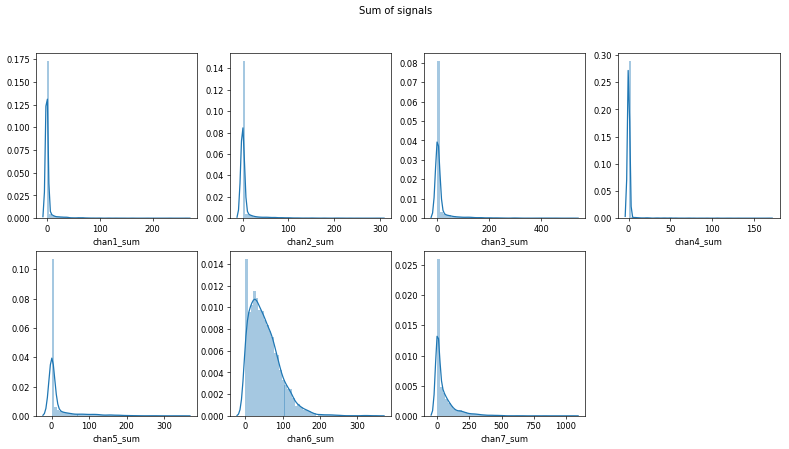

In [7]:
plot_marker_distribution(sum_data,title='Sum of signals')

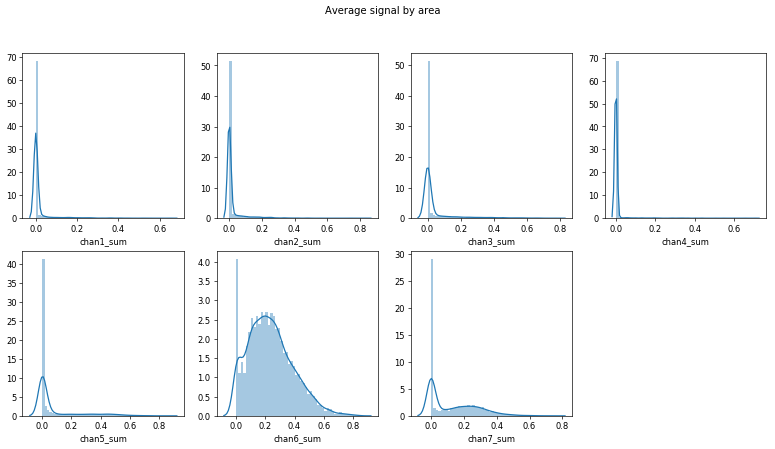

In [8]:
plot_marker_distribution(average_data,'Average signal by area')

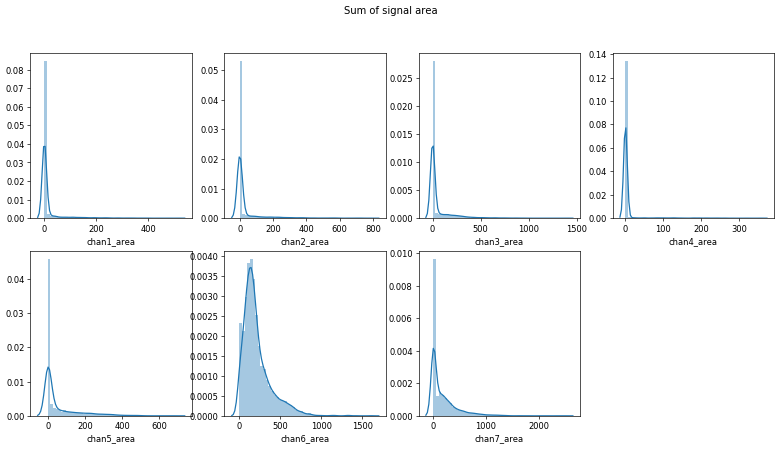

In [9]:
plot_marker_distribution(area_data,'Sum of signal area')

## Co-expression 

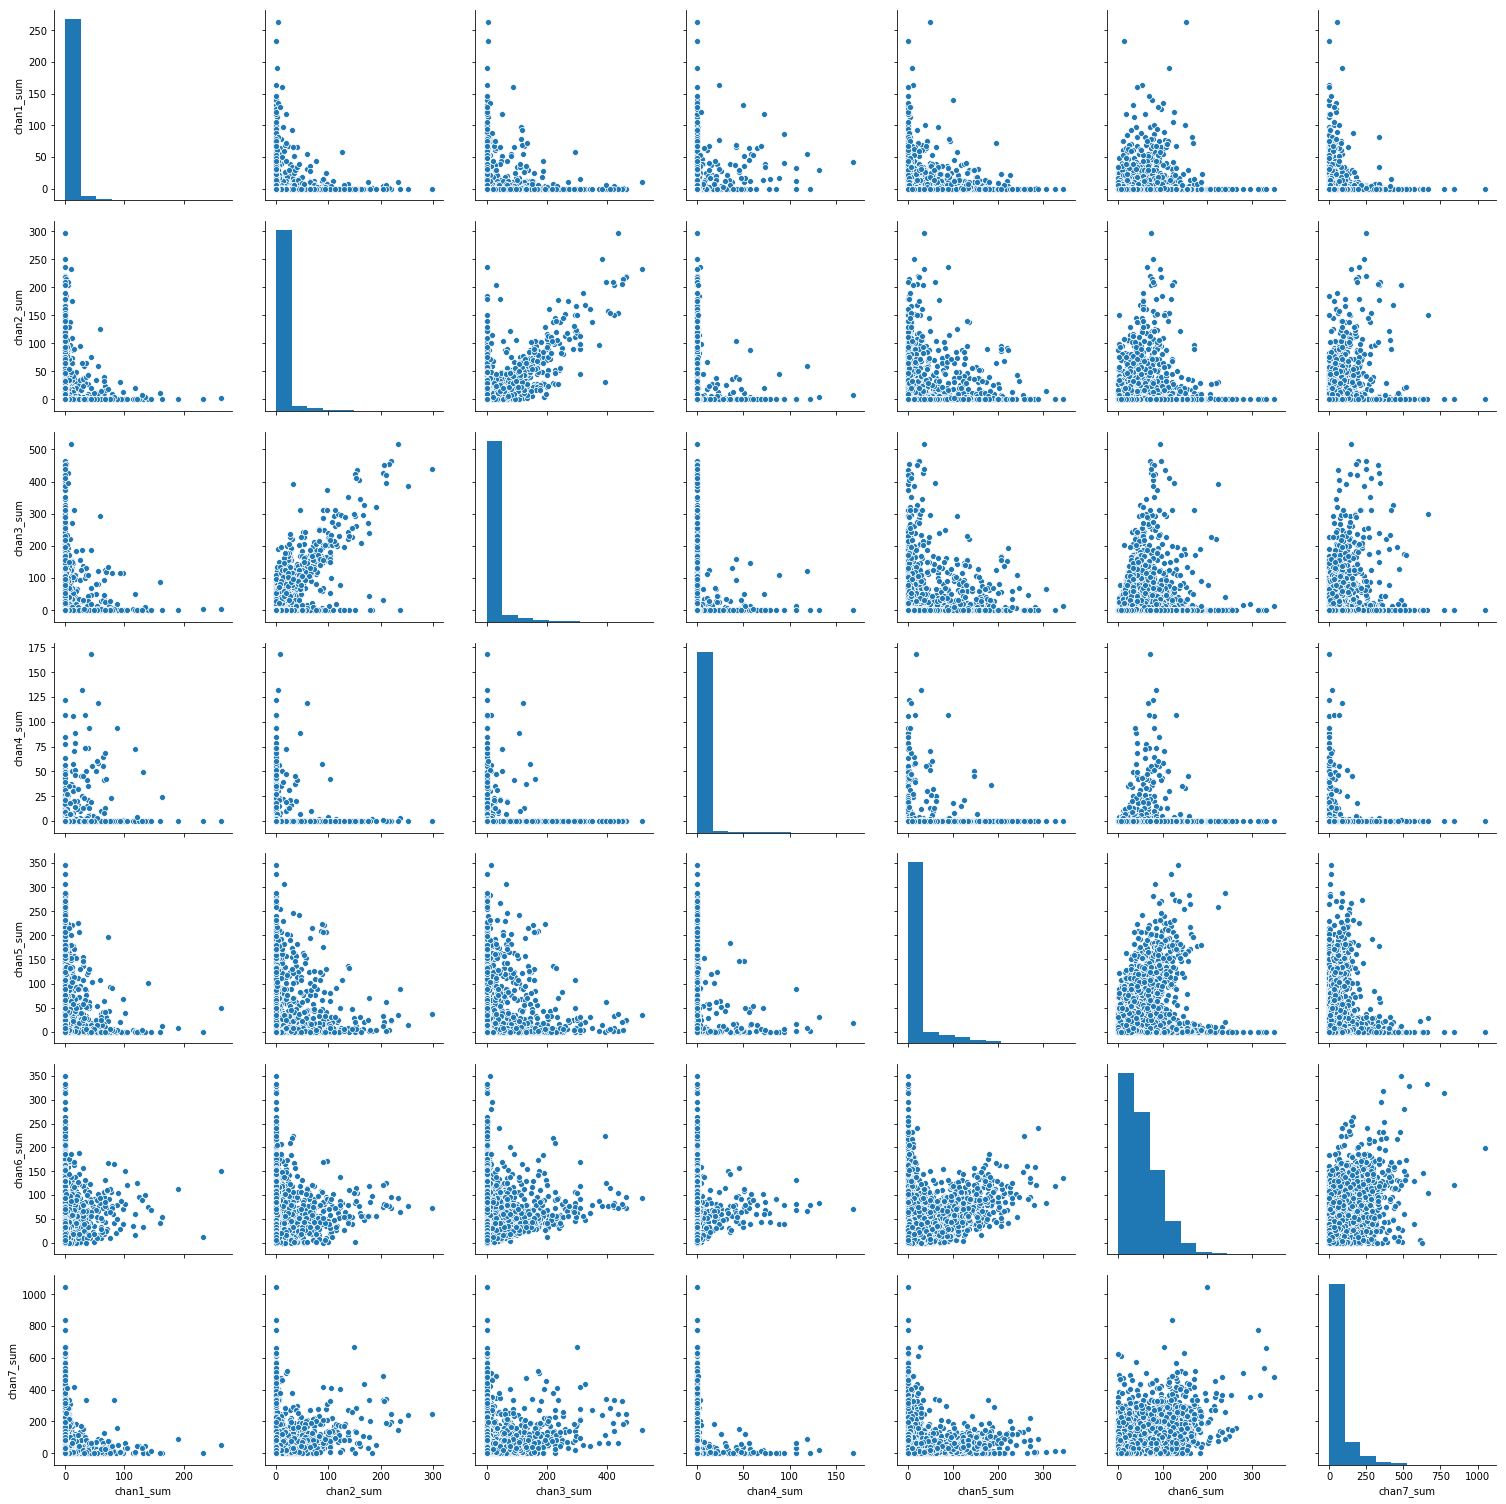

In [10]:
sns.pairplot(sum_data, height=3);

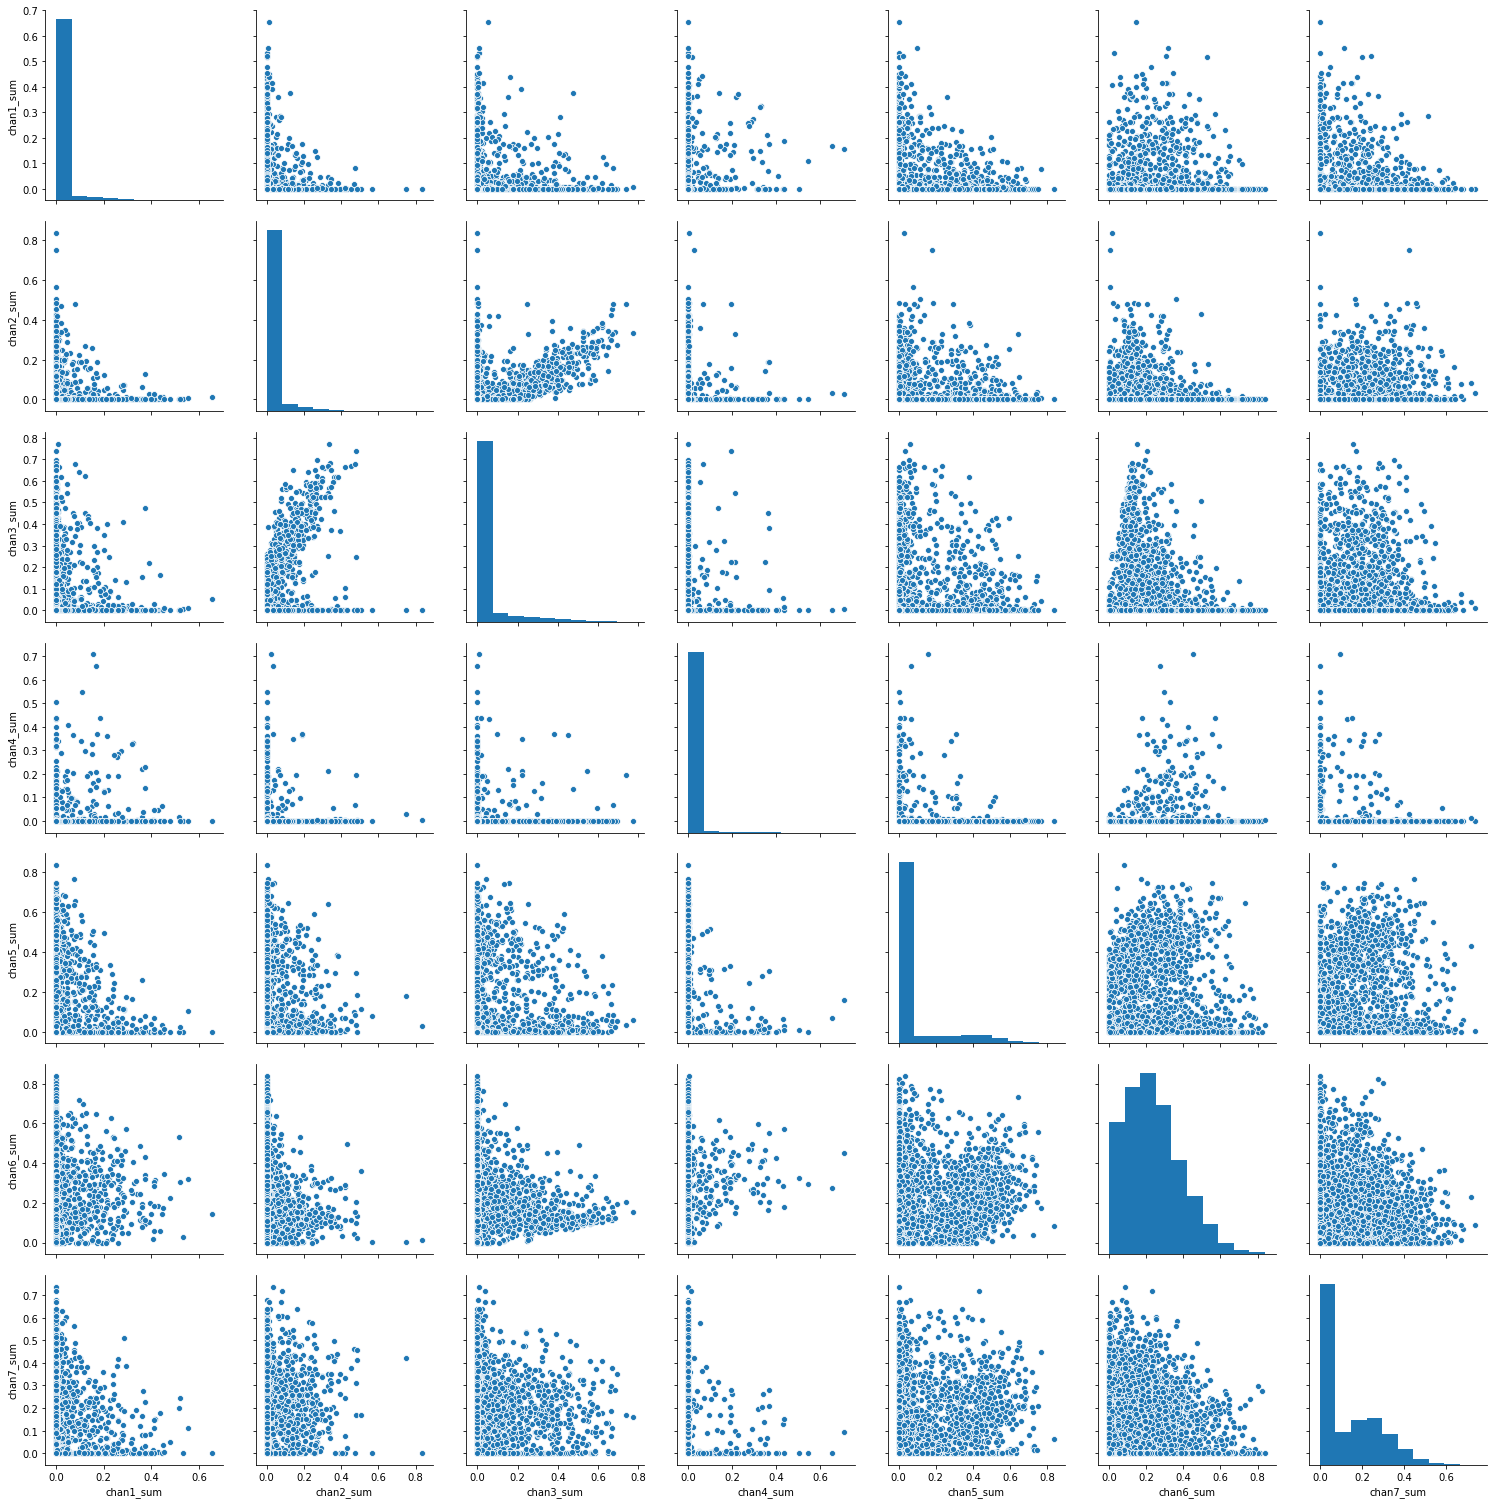

In [11]:
sns.pairplot(average_data, height=3);

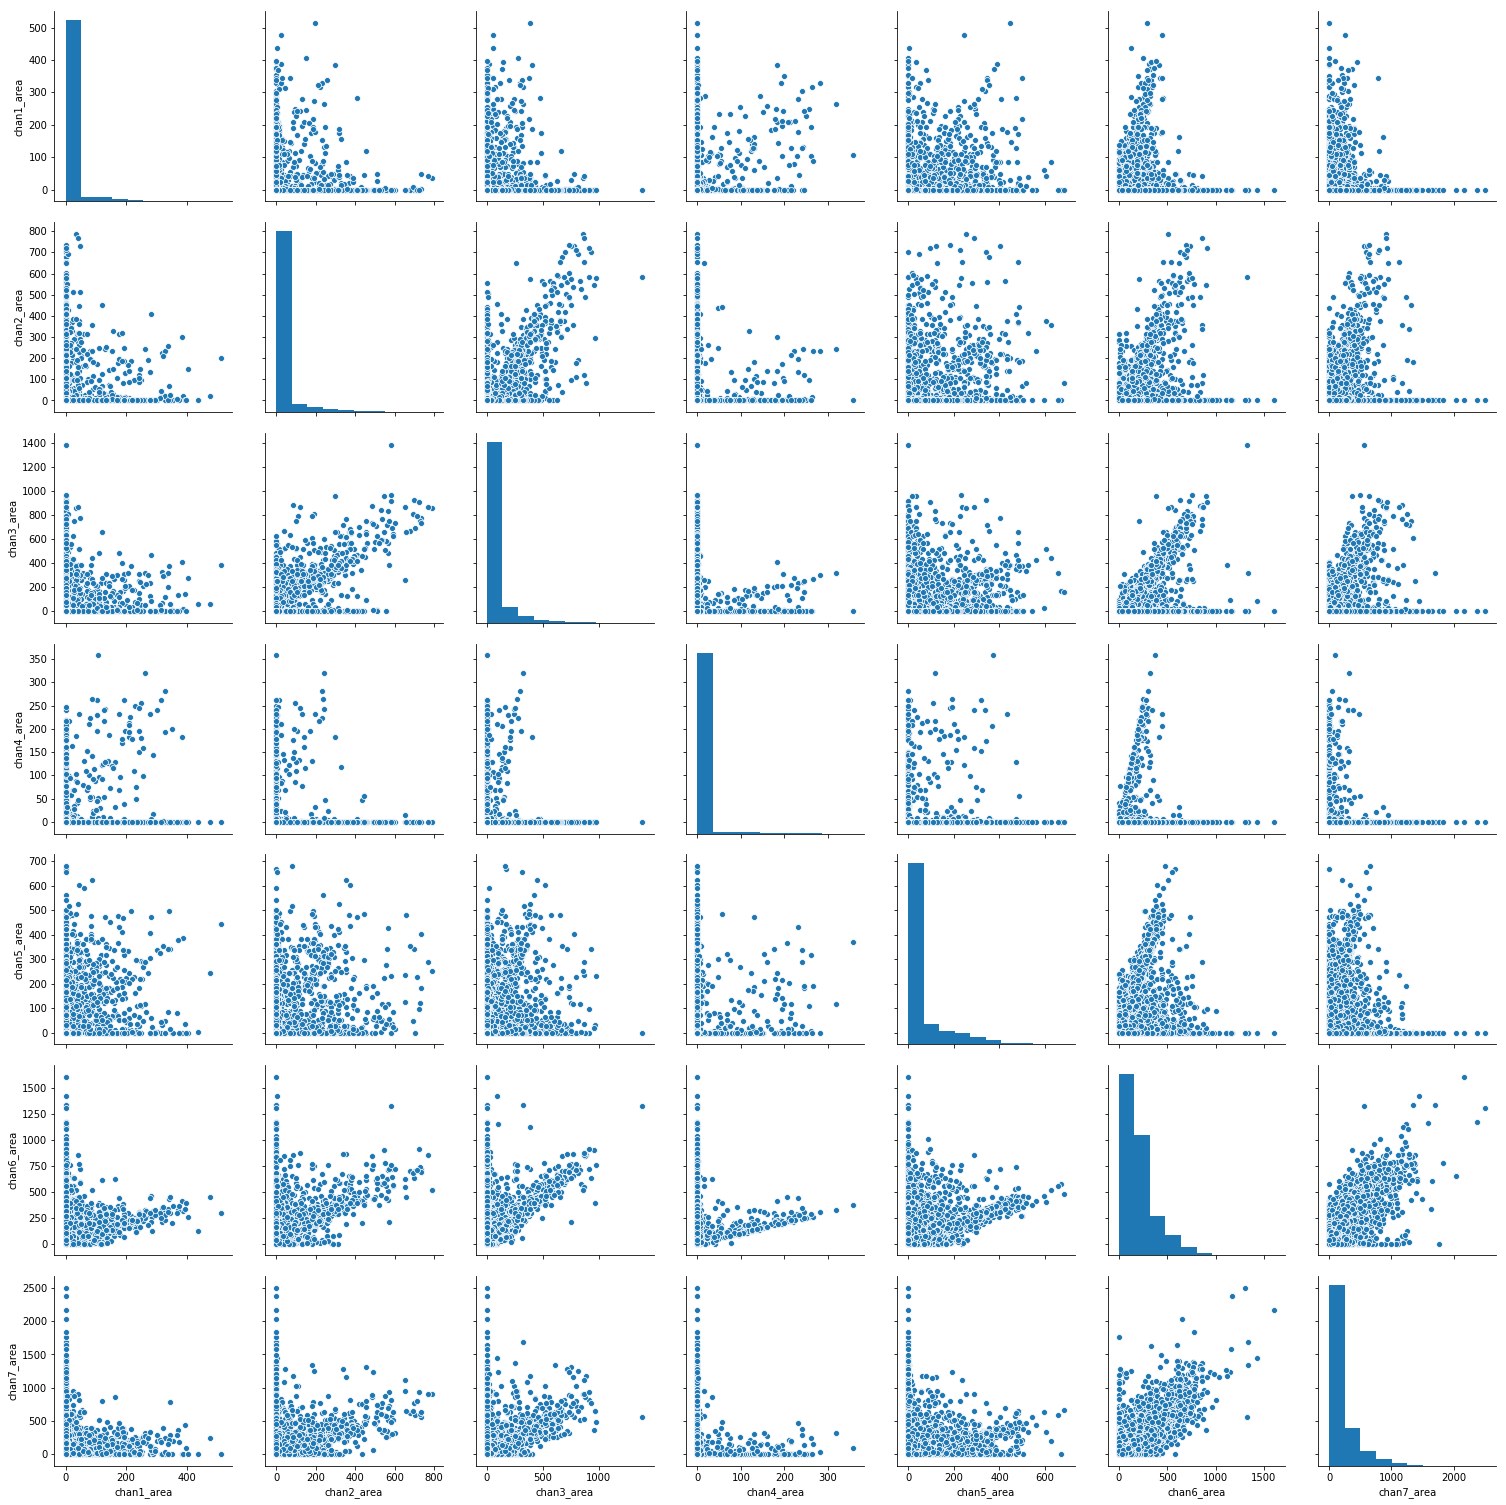

In [12]:
sns.pairplot(area_data, height=3);

## Cell_typing

In [37]:
channel_list = ['chan1', 'chan2', 'chan3', 'chan4', 'chan5', 'chan6', 'chan7'] 

After checking the distribution of the signals, we set that to say one marker is positive, the average signal intensity and the signal area should be above certain number. You can set the threshold differently for different channel.

In [48]:
ave_threshold_list = [0.10,0.1,0.10,0.1,0.10,0.10,0.1]
area_threshold=36
cell_typing = pd.DataFrame(np.zeros(average_data.shape),columns=channel_list)
for i in range(7):
    cell_typing.iloc[:,i]= (average_data.iloc[:,i]>ave_threshold_list[i]).values

However, when two cell is very close by, the signal can be mixed. In this case, the users should list the markers that do not express in one cell. For two common markers, the final marker should be the stronger ones. For tumor and immune, once the immune signals are strong enough, it should be always immune signal.

In [51]:
cell_typing.loc[area_data['chan6_area']>area_threshold,'chan6']=True
cell_typing.loc[area_data['chan6_area']<area_threshold,['chan1', 'chan2', 'chan3', 'chan4', 'chan5', 'chan7']]= [False]*(len(channel_list)-1)

In [52]:
cell_typing.loc[(average_data['chan5_sum']>=average_data['chan4_sum']) & (average_data['chan4_sum']==True) & (average_data['chan5_sum']==True),'chan4']=False
cell_typing.loc[(average_data['chan5_sum']<average_data['chan4_sum']) & (average_data['chan4_sum']==True) & (average_data['chan5_sum']==True),'chan5']=False
cell_typing.loc[average_data['chan5_sum']>0.2,'chan7']=False
cell_typing.loc[average_data['chan4_sum']>0.2,'chan7']=False


## Visualization of Cell type

This allows visualization of channel positive cells. You can use this as validation to your threshold set before. You can always go back to reset the threshold if the results are not good.

In [53]:
rgb_images = sorted(glob.glob('../data/RGB_2/*.png'))
tiff_images = sorted(glob.glob('../data/tif/*.tif'))

In [54]:
sampling_size=10
box_size=25
image_radius=50

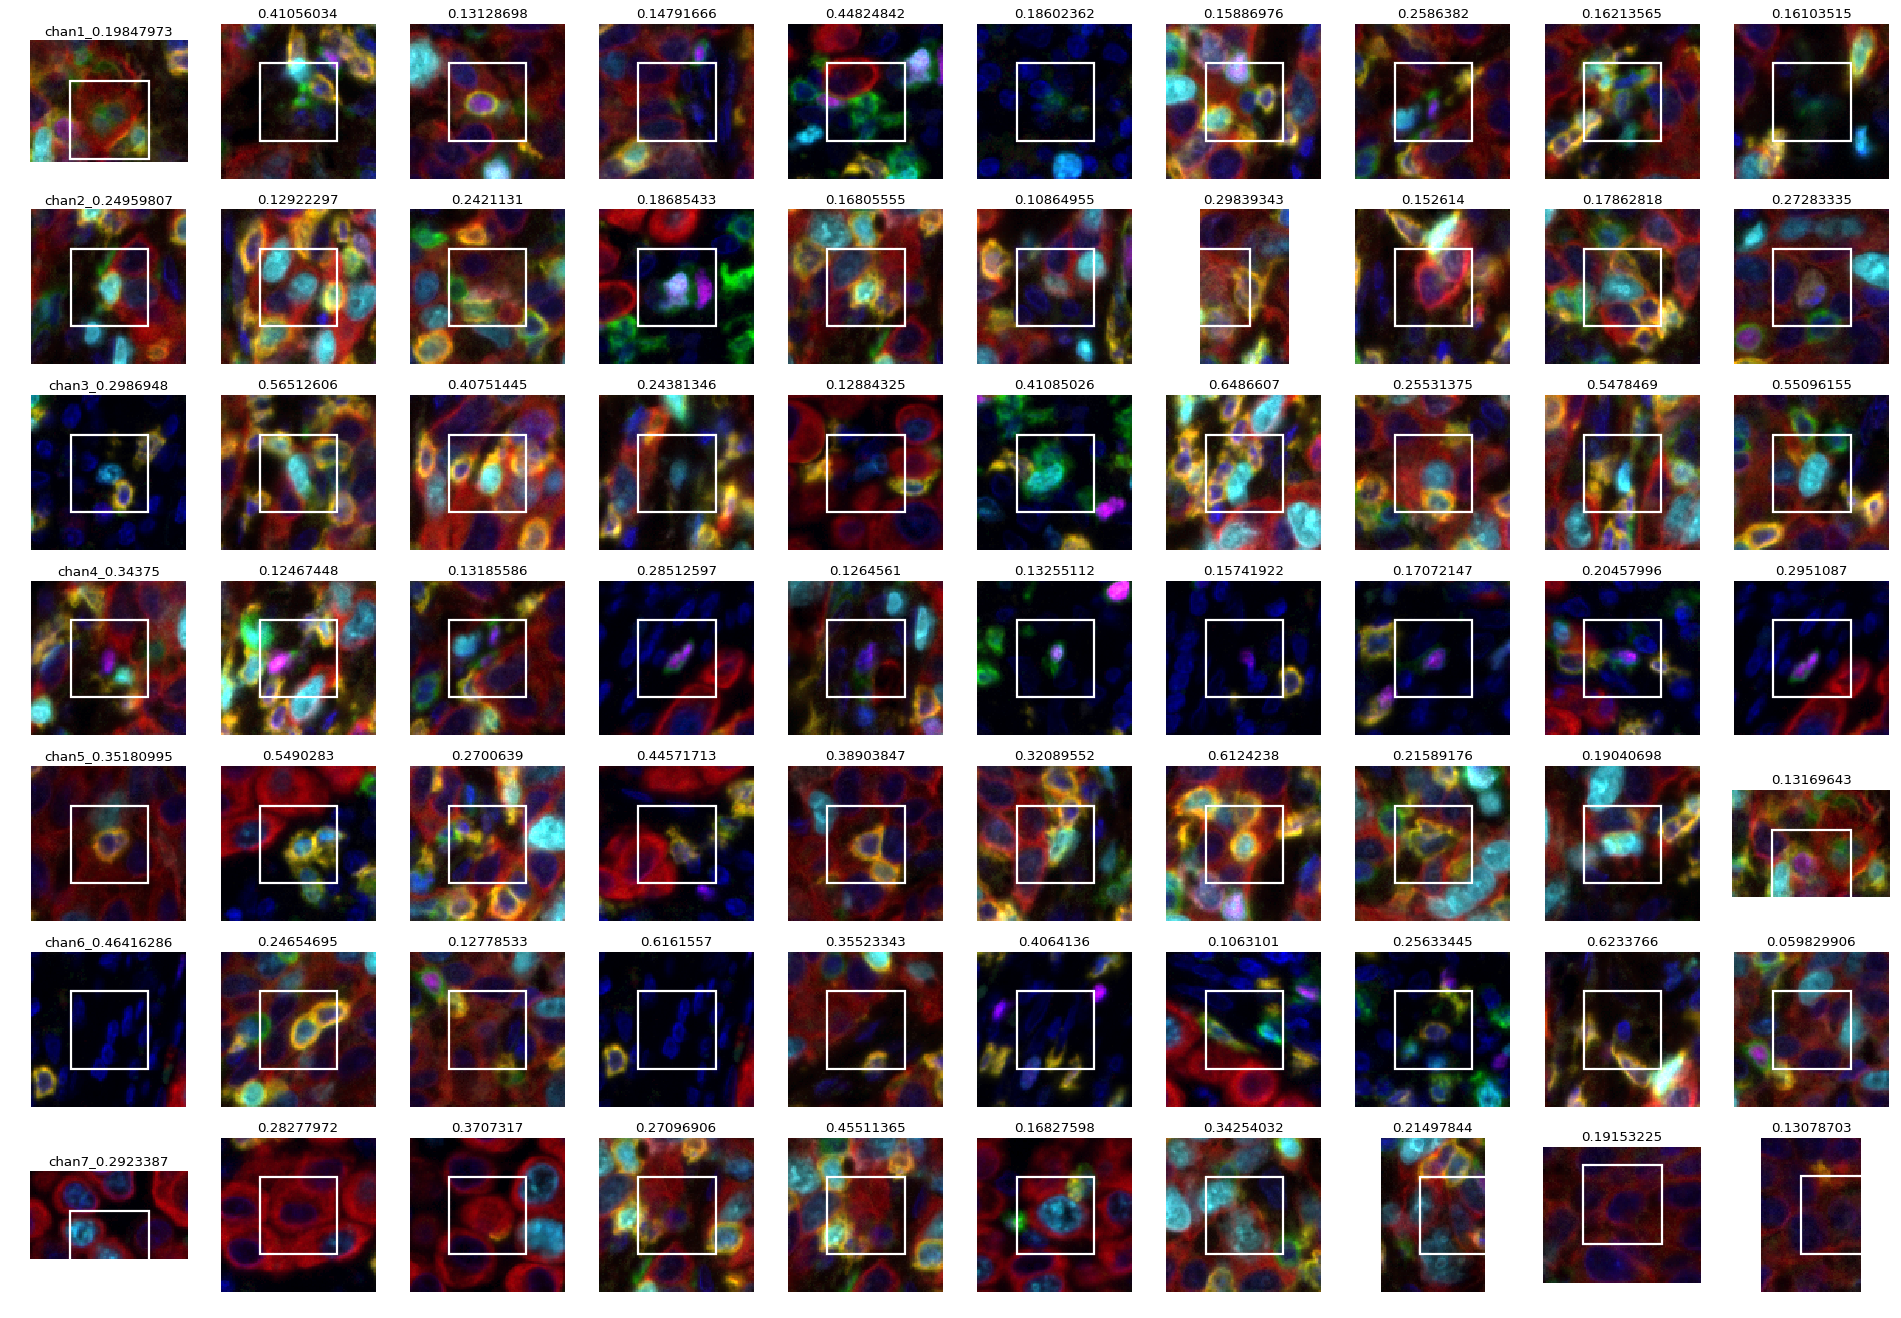

In [68]:
plt.figure(figsize=(sampling_size*3,len(channel_list)*3),dpi=80)
for i in range(len(channel_list)):
    target_df = sample_df[cell_typing.loc[:,channel_list[i]]==1].sample(n=sampling_size,random_state=100)
    for j in range(sampling_size):
        image_arr = imageio.imread(rgb_images[target_df['id_image'].values[j]])
        ax2 = plt.subplot(len(channel_list),sampling_size,i*sampling_size+j+1)
        x_ = int(target_df['centroid_x'].values[j])
        y_ = int(target_df['centroid_y'].values[j])
        ax2.imshow( image_arr[max(x_-image_radius,0):min((x_+image_radius),image_arr.shape[0]),max(y_-image_radius,0):min(y_+image_radius,image_arr.shape[1])])
        rect = patches.Rectangle( (y_-max(y_-image_radius,0)-box_size,x_-max(x_-image_radius,0) -box_size),box_size*2,box_size*2,linewidth=2,edgecolor='w',facecolor='none')

        ax2.add_patch(rect)
        ax2.set_axis_off()
        if j==0:
            ax2.title.set_text(channel_list[i] + '_' +str(target_df.iloc[j,10+2*i]/target_df.iloc[j,3]))
        else: 
            ax2.title.set_text(str(target_df.iloc[j,10+2*i]/target_df.iloc[j,3]))
        


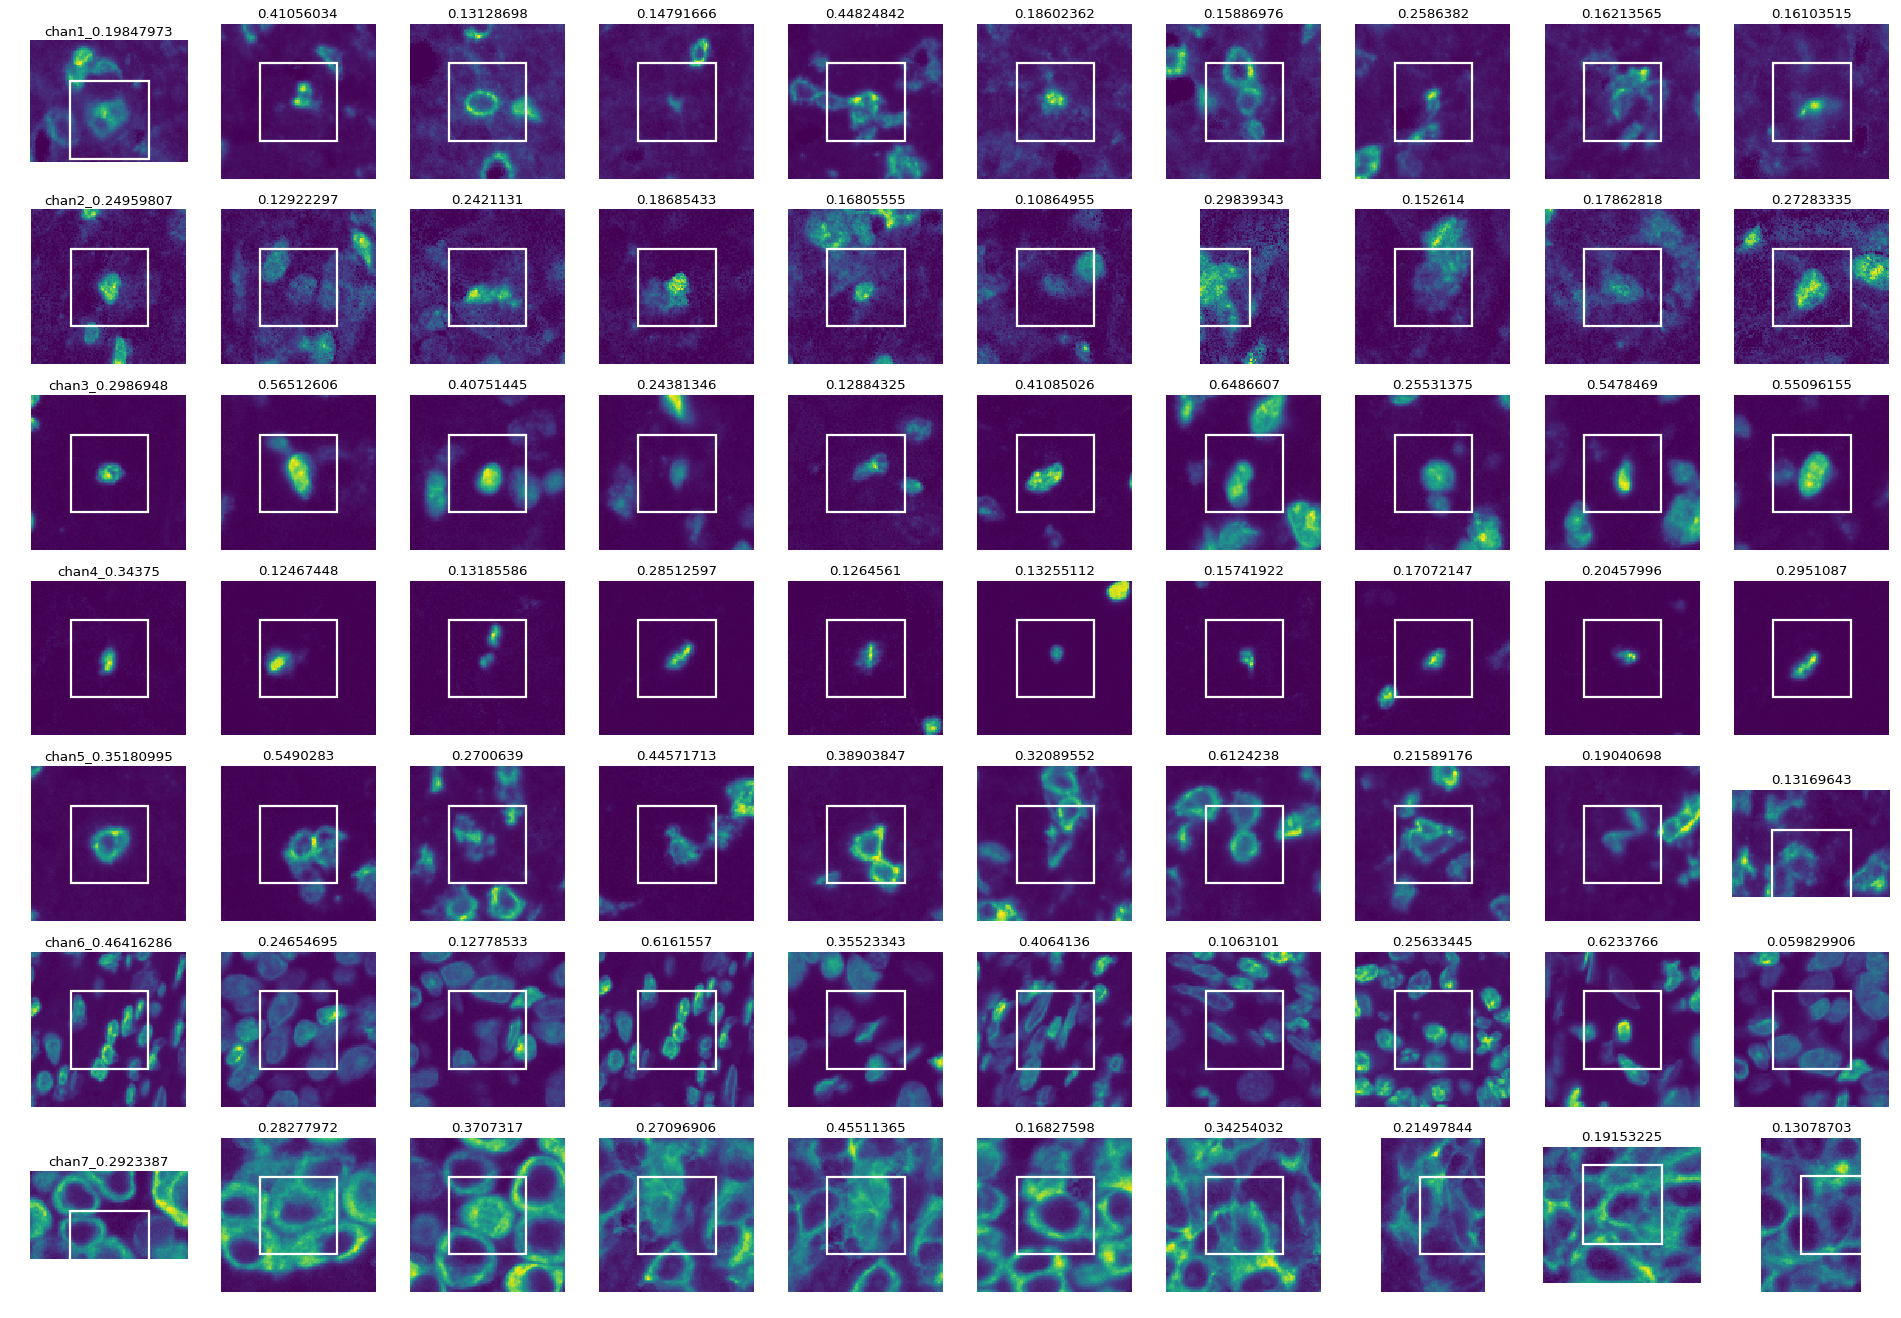

In [66]:
plt.figure(figsize=(sampling_size*3,len(channel_list)*3),dpi=80,facecolor='white')
for i in range(len(channel_list)):
    target_df = sample_df[cell_typing.loc[:,channel_list[i]]==1].sample(n=sampling_size,random_state=100)
    for j in range(sampling_size):
        image_arr = tifffile.imread(tiff_images[target_df['id_image'].values[j]])[i]
        ax2 = plt.subplot(len(channel_list),sampling_size,i*sampling_size+j+1)
        x_ = int(target_df['centroid_x'].values[j])
        y_ = int(target_df['centroid_y'].values[j])
        ax2.imshow( image_arr[max(x_-image_radius,0):min((x_+image_radius),image_arr.shape[0]),max(y_-image_radius,0):min(y_+image_radius,image_arr.shape[1])])
        rect = patches.Rectangle( (y_-max(y_-image_radius,0)-box_size,x_-max(x_-image_radius,0) -box_size),box_size*2,box_size*2,linewidth=2,edgecolor='w',facecolor='none')

        ax2.add_patch(rect)
        ax2.set_axis_off()
        if j==0:
            ax2.title.set_text(channel_list[i] + '_' +str(target_df.iloc[j,10+2*i]/target_df.iloc[j,3]))
        else: 
            ax2.title.set_text(str(target_df.iloc[j,10+2*i]/target_df.iloc[j,3]))

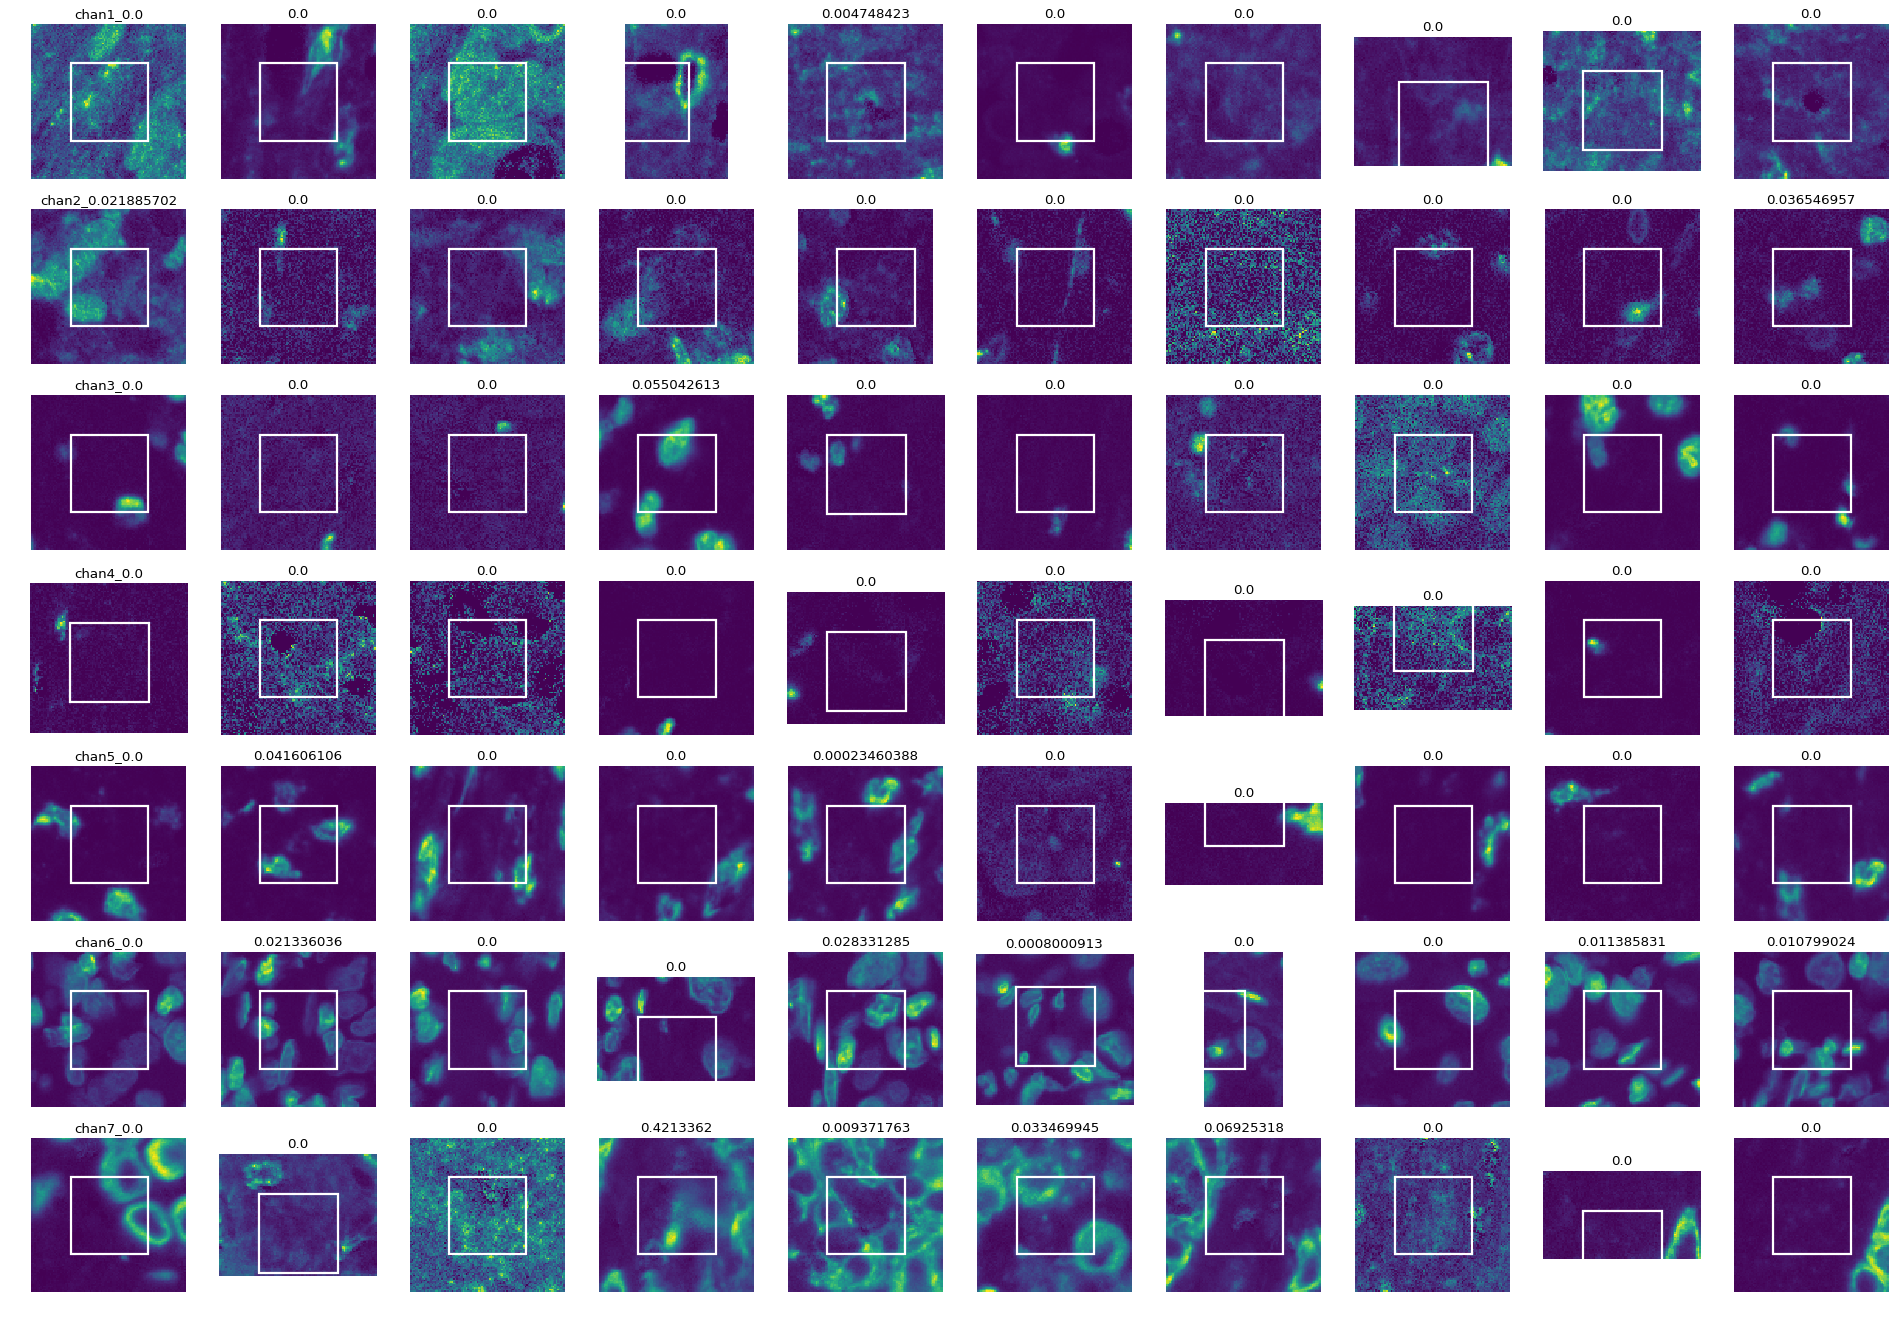

In [67]:
plt.figure(figsize=(sampling_size*3,len(channel_list)*3),dpi=80,facecolor='white')
for i in range(len(channel_list)):
    target_df = sample_df[cell_typing.loc[:,channel_list[i]]==0].sample(n=sampling_size,random_state=100)
    for j in range(sampling_size):
        image_arr = tifffile.imread(tiff_images[target_df['id_image'].values[j]])[i]
        ax2 = plt.subplot(len(channel_list),sampling_size,i*sampling_size+j+1)
        x_ = int(target_df['centroid_x'].values[j])
        y_ = int(target_df['centroid_y'].values[j])
        ax2.imshow( image_arr[max(x_-image_radius,0):min((x_+image_radius),image_arr.shape[0]),max(y_-image_radius,0):min(y_+image_radius,image_arr.shape[1])])
        rect = patches.Rectangle( (y_-max(y_-image_radius,0)-box_size,x_-max(x_-image_radius,0) -box_size),box_size*2,box_size*2,linewidth=2,edgecolor='w',facecolor='none')

        ax2.add_patch(rect)
        ax2.set_axis_off()
        if j==0:
            ax2.title.set_text(channel_list[i] + '_' +str(target_df.iloc[j,10+2*i]/target_df.iloc[j,3]))
        else: 
            ax2.title.set_text(str(target_df.iloc[j,10+2*i]/target_df.iloc[j,3]))

## Quick analysis on marker co-expression

In [69]:
cell_typing.describe()

chan1  chan2  chan3  chan4  chan5 chan6  chan7
count    5145   5145   5145   5145   5145  5145   5145
unique      2      2      2      2      2     2      2
top     False  False  False  False  False  True  False
freq     4910   4825   4510   5060   4216  4775   3488

In [70]:
matrix=np.zeros((7,7))
for i in range(7):
    for j in range(7):
        matrix[i,j]=len(cell_typing[(cell_typing[channel_list[i]]==1) & (cell_typing[channel_list[j]]==1)])/len(cell_typing[cell_typing[channel_list[i]]==1])

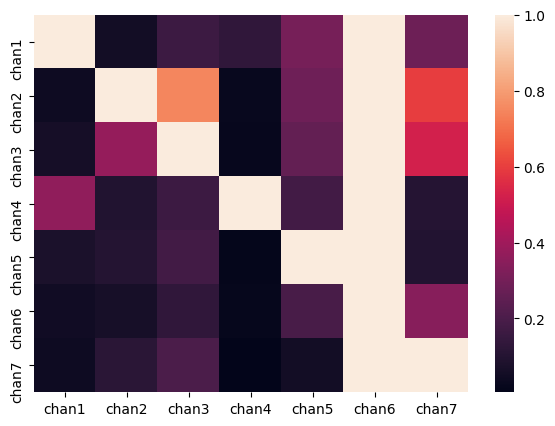

In [71]:
plt.figure(figsize=(7,5),dpi=100,facecolor='white')
sns.heatmap(matrix,xticklabels=channel_list,yticklabels=channel_list)

## Save matrix

In [64]:
sample_df[channel_list]=cell_typing

In [65]:
sample_df.to_hdf('../data/feature_matrix/demo_matrix.h5','df')